In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "ms",
    "timezone": "auto",
    "forecast_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Save to CSV
csv_filename = "london_hourly_weather.csv"
hourly_dataframe.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

print(hourly_dataframe)

Coordinates 51.5°N -0.12000012397766113°E
Elevation 23.0 m asl
Timezone b'Europe/London' None
Timezone difference to GMT+0 0 s
CSV saved: london_hourly_weather.csv
                         date  temperature_2m  relative_humidity_2m  \
0   2025-02-16 00:00:00+00:00       37.643002                  75.0   
1   2025-02-16 01:00:00+00:00       37.643002                  72.0   
2   2025-02-16 02:00:00+00:00       37.553001                  71.0   
3   2025-02-16 03:00:00+00:00       37.373001                  73.0   
4   2025-02-16 04:00:00+00:00       37.283001                  75.0   
..                        ...             ...                   ...   
163 2025-02-22 19:00:00+00:00       52.355301                  79.0   
164 2025-02-22 20:00:00+00:00       51.365299                  82.0   
165 2025-02-22 21:00:00+00:00       50.645302                  84.0   
166 2025-02-22 22:00:00+00:00       50.465302                  85.0   
167 2025-02-22 23:00:00+00:00       50.735302          

In [2]:
import pandas as pd
fut_df = pd.read_csv(csv_filename)

In [3]:
fut_df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m
0,2025-02-16 00:00:00+00:00,37.643,75.0,30.436161,2.617250,96.581856,5.4
1,2025-02-16 01:00:00+00:00,37.643,72.0,29.432463,2.154066,111.801476,5.3
2,2025-02-16 02:00:00+00:00,37.553,71.0,29.003080,2.451530,101.768265,5.3
3,2025-02-16 03:00:00+00:00,37.373,73.0,29.510590,2.121320,98.130020,5.4
4,2025-02-16 04:00:00+00:00,37.283,75.0,30.087770,2.801785,87.954640,5.8


In [4]:
fut_df.rename(columns={'date': 'Time'}, inplace=True)
fut_df['Time'] = pd.to_datetime(fut_df['Time'])
fut_df['Year']=fut_df['Time'].dt.year
fut_df['Month']=fut_df['Time'].dt.month

In [5]:
fut_df['Hour'] = fut_df['Time'].dt.hour

In [6]:
fut_df

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour
0,2025-02-16 00:00:00+00:00,37.643000,75.0,30.436161,2.617250,96.581856,5.4,2025,2,0
1,2025-02-16 01:00:00+00:00,37.643000,72.0,29.432463,2.154066,111.801476,5.3,2025,2,1
2,2025-02-16 02:00:00+00:00,37.553000,71.0,29.003080,2.451530,101.768265,5.3,2025,2,2
3,2025-02-16 03:00:00+00:00,37.373000,73.0,29.510590,2.121320,98.130020,5.4,2025,2,3
4,2025-02-16 04:00:00+00:00,37.283000,75.0,30.087770,2.801785,87.954640,5.8,2025,2,4
...,...,...,...,...,...,...,...,...,...,...
163,2025-02-22 19:00:00+00:00,52.355300,79.0,46.035720,2.121320,188.130020,6.2,2025,2,19
164,2025-02-22 20:00:00+00:00,51.365300,82.0,46.056206,1.711724,186.709750,4.9,2025,2,20
165,2025-02-22 21:00:00+00:00,50.645300,84.0,45.988930,1.513275,187.594560,3.7,2025,2,21
166,2025-02-22 22:00:00+00:00,50.465300,85.0,46.125390,1.603122,183.576260,4.0,2025,2,22


In [7]:
import numpy as np
min_year = fut_df['Year'].min()
max_year = fut_df['Year'].max()
fut_df['Month_sin'] = np.sin(2 * np.pi * fut_df['Month'] / 12)
fut_df['Month_cos'] = np.cos(2 * np.pi * fut_df['Month'] / 12)

In [8]:
fut_df['Day'] = fut_df['Time'].dt.day
fut_df['Day_sin'] = np.sin(2 * np.pi * fut_df['Day'] / 31) 
fut_df['Day_cos'] = np.cos(2 * np.pi * fut_df['Day'] / 31)
fut_df['Hour_sin'] = np.sin(2 * np.pi * fut_df['Hour'] / 24) 
fut_df['Hour_cos'] = np.cos(2 * np.pi * fut_df['Hour'] / 24)

In [9]:
fut_df.head()

,Time,temperature_2m,relative_humidity_2m,dew_point_2m,wind_speed_10m,wind_direction_10m,wind_gusts_10m,Year,Month,Hour,Month_sin,Month_cos,Day,Day_sin,Day_cos,Hour_sin,Hour_cos
0,2025-02-16 00:00:00+00:00,37.643,75.0,30.436161,2.617250,96.581856,5.4,2025,2,0,0.866025,0.5,16,-0.101168,-0.994869,0.000000,1.000000
1,2025-02-16 01:00:00+00:00,37.643,72.0,29.432463,2.154066,111.801476,5.3,2025,2,1,0.866025,0.5,16,-0.101168,-0.994869,0.258819,0.965926
2,2025-02-16 02:00:00+00:00,37.553,71.0,29.003080,2.451530,101.768265,5.3,2025,2,2,0.866025,0.5,16,-0.101168,-0.994869,0.500000,0.866025
3,2025-02-16 03:00:00+00:00,37.373,73.0,29.510590,2.121320,98.130020,5.4,2025,2,3,0.866025,0.5,16,-0.101168,-0.994869,0.707107,0.707107
4,2025-02-16 04:00:00+00:00,37.283,75.0,30.087770,2.801785,87.954640,5.8,2025,2,4,0.866025,0.5,16,-0.101168,-0.994869,0.866025,0.500000


In [10]:
""" import pickle
with open('random_forest_model.pkl', 'rb') as f:
    model = pickle.load(f)
 """
import pickle
with open("random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

In [11]:
fut_df.rename(columns={"relative_humidity_2m":"relativehumidity_2m", "dew_point_2m":"dewpoint_2m", "wind_speed_10m":"windspeed_10m", "wind_direction_10m":"winddirection_10m", "wind_gusts_10m":"windgusts_10m"}, inplace=True)

In [12]:
pred_df = fut_df.drop(columns=["Time","Day","Year","Month","Hour"])
y_pred = model.predict(pred_df)

In [13]:
y_pred

array([0.269604  , 0.29394867, 0.27155933, 0.24069671, 0.277569  ,
       0.27906333, 0.27883933, 0.337731  , 0.26459733, 0.52935167,
       0.27335867, 0.272198  , 0.24797333, 0.33817667, 0.37160567,
       0.397192  , 0.56359767, 0.59058867, 0.38471933, 0.32639833,
       0.248871  , 0.26026433, 0.38694067, 0.33024567, 0.280975  ,
       0.22967467, 0.19695133, 0.18107867, 0.15616483, 0.24230833,
       0.23808967, 0.14809214, 0.15329395, 0.14677533, 0.224764  ,
       0.210782  , 0.27360167, 0.244412  , 0.220555  , 0.264211  ,
       0.240704  , 0.325133  , 0.39390867, 0.32054633, 0.36991367,
       0.25809833, 0.263687  , 0.277233  , 0.323109  , 0.23200067,
       0.22738333, 0.18938047, 0.21470567, 0.15231946, 0.161762  ,
       0.17495133, 0.168655  , 0.13696367, 0.18533867, 0.14132533,
       0.17032067, 0.22023433, 0.32708933, 0.31219933, 0.25589   ,
       0.24331433, 0.29332833, 0.33597033, 0.35333867, 0.351886  ,
       0.303603  , 0.187123  , 0.17418067, 0.2244408 , 0.18392

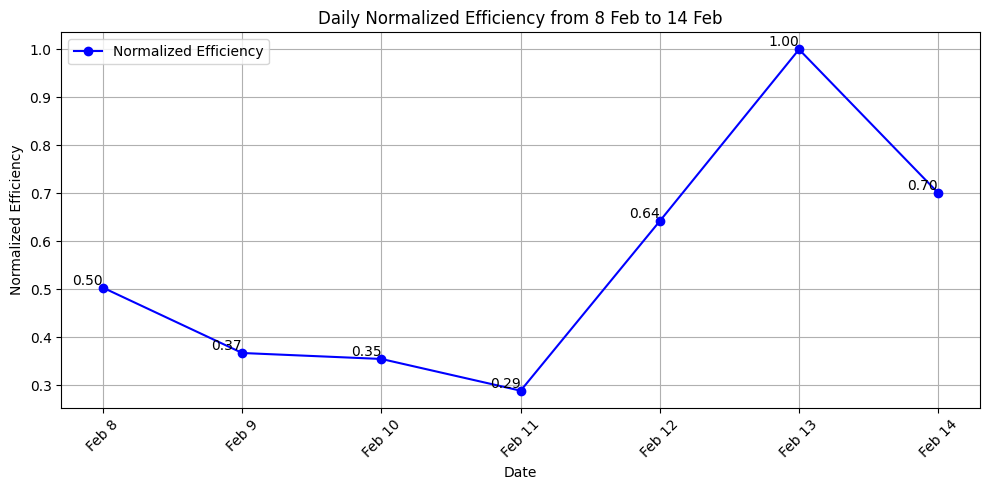

'normalized_efficiency_plot.png'

In [14]:
import numpy as np
import matplotlib.pyplot as plt

efficiency_values = y_pred

daily_efficiency = efficiency_values.reshape(-1, 24).sum(axis=1)
normalized_efficiency = daily_efficiency / daily_efficiency.max()  # Normalize

dates = [f"Feb {i}" for i in range(8, 15)]

plt.figure(figsize=(10, 5))
plt.plot(dates, normalized_efficiency, marker='o', linestyle='-', color='b', label="Normalized Efficiency")

for i, txt in enumerate(normalized_efficiency):
    plt.text(dates[i], normalized_efficiency[i], f"{txt:.2f}", ha='right', va='bottom', fontsize=10)

plt.xlabel("Date")
plt.ylabel("Normalized Efficiency")
plt.title("Daily Normalized Efficiency from 8 Feb to 14 Feb")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
image_path = "normalized_efficiency_plot.png"
plt.savefig(image_path, dpi=300)
plt.show()

image_path


In [15]:
df_efficiency = pd.DataFrame({
    "Date": dates,
    "Normalized_Efficiency": normalized_efficiency
})

# Save to CSV
csv_path = "efficiency_data.csv"
df_efficiency.to_csv(csv_path, index=False)

# Display the table
print(df_efficiency)

csv_path

     Date  Normalized_Efficiency
0   Feb 8               0.503096
1   Feb 9               0.366968
2  Feb 10               0.354523
3  Feb 11               0.288351
4  Feb 12               0.642133
5  Feb 13               1.000000
6  Feb 14               0.700528


'efficiency_data.csv'

In [16]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 51.5085,
    "longitude": -0.1257,
    "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "ms",
    "timezone": "auto",
    "forecast_days": 7
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

# Save to CSV
csv_filename = "london_hourly_weather.csv"
hourly_dataframe.to_csv(csv_filename, index=False)
print(f"CSV saved: {csv_filename}")

print(hourly_dataframe)

Coordinates 51.5°N -0.12000012397766113°E
Elevation 23.0 m asl
Timezone b'Europe/London' None
Timezone difference to GMT+0 0 s
CSV saved: london_hourly_weather.csv
                         date  temperature_2m  relative_humidity_2m  \
0   2025-02-16 00:00:00+00:00       37.643002                  75.0   
1   2025-02-16 01:00:00+00:00       37.643002                  72.0   
2   2025-02-16 02:00:00+00:00       37.553001                  71.0   
3   2025-02-16 03:00:00+00:00       37.373001                  73.0   
4   2025-02-16 04:00:00+00:00       37.283001                  75.0   
..                        ...             ...                   ...   
163 2025-02-22 19:00:00+00:00       52.355301                  79.0   
164 2025-02-22 20:00:00+00:00       51.365299                  82.0   
165 2025-02-22 21:00:00+00:00       50.645302                  84.0   
166 2025-02-22 22:00:00+00:00       50.465302                  85.0   
167 2025-02-22 23:00:00+00:00       50.735302          